In [41]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
import tensorflow as tf
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import seaborn as sns


from tensorflow.python.client import device_lib
device_lib.list_local_devices()
tf.test.is_gpu_available()



urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt", filename="ratings_total.txt")



total_data = pd.read_table('ratings_total.txt', names=['ratings', 'reviews'])



total_data['label'] = np.select([total_data.ratings > 3], [1], default=0)



total_data.drop_duplicates(subset=['reviews'], inplace=True)



# 훈련 데이터와 테스트 데이터를 3:1 비율로 분리
train_data, test_data = train_test_split(total_data, test_size = 0.25, random_state = 42)



# 한글과 공백을 제외하고 모두 제거
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['reviews'].replace('', np.nan, inplace=True)



# 중복 제거
test_data.drop_duplicates(subset = ['reviews'], inplace=True) 
# 정규 표현식 수행
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") 
# 공백은 Null 값으로 변경
test_data['reviews'].replace('', np.nan, inplace=True) 
# Null 값 제거
test_data = test_data.dropna(how='any') 



from eunjeon import Mecab
mecab = Mecab()



stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']



train_data['tokenized'] = train_data['reviews'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])
test_data['tokenized'] = test_data['reviews'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])



X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values



# 기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 텍스트 데이터에 정수 인코딩 수행

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)



# 단어 집합이 생성되는 동시에 각 단어에 고유한 정수 부여
# 등장 횟수가 1회인 단어들은 자연어 처리에서 배제

threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)



# 단어 집합 크기를 토크나이저의 인자로 넘겨주고, 텍스트 시퀀스를 정수 시퀀스로 변환
# 정수 인코딩 과정에서 이보다 큰 숫자가 부여된 단어들은 OOV로 변환

# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)



tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)



# 패딩
# 서로 다른 길이의 샘플들의 길이를 동일하게 맞춰주는 작업

def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))



max_len = 80
below_threshold_len(max_len, X_train)



# 훈련용 리뷰의 99.99가 80이하의 길이를 가지기 때문에, 훈련용 리뷰를 길이 80으로 패딩

X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)



# GRU로 네이버 쇼핑 리뷰 감성 분류

from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
    
embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(GRU(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)



loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))



def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = mecab.morphs(new_sentence)
  new_sentence = [word for word in new_sentence if not word in stopwords]
  encoded = tokenizer.texts_to_sequences([new_sentence])
  pad_new = pad_sequences(encoded, maxlen = max_len)

  score = float(loaded_model.predict(pad_new))
  if(score > 0.6):
    print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
    return 1
  elif(score < 0.4):
    print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))
    return -1
  else:
    print("{:.2f}% 확률로 중립 리뷰입니다.".format((1 - score) * 100))
    return 0



sentiment_predict("불친절")

C:\Users\jeonj\AppData\Local\Temp\ipykernel_9880\771293321.py:44: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
C:\Users\jeonj\AppData\Local\Temp\ipykernel_9880\771293321.py:52: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


단어 집합(vocabulary)의 크기 : 39741
등장 빈도가 1번 이하인 희귀 단어의 수: 18056
단어 집합에서 희귀 단어의 비율: 45.43418635665937
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.7869324583053495
단어 집합의 크기 : 21687
전체 샘플 중 길이가 80 이하인 샘플의 비율: 99.99933302652553
Epoch 1/15
1873/1875 [============================>.] - ETA: 0s - loss: 0.2741 - acc: 0.8982
Epoch 1: val_acc improved from -inf to 0.91756, saving model to best_model.h5
1875/1875 [==============================] - 31s 15ms/step - loss: 0.2741 - acc: 0.8982 - val_loss: 0.2262 - val_acc: 0.9176
Epoch 2/15
1873/1875 [============================>.] - ETA: 0s - loss: 0.2152 - acc: 0.9226
Epoch 2: val_acc improved from 0.91756 to 0.92467, saving model to best_model.h5
1875/1875 [==============================] - 27s 14ms/step - loss: 0.2152 - acc: 0.9226 - val_loss: 0.2080 - val_acc: 0.9247
Epoch 3/15
1871/1875 [============================>.] - ETA: 0s - loss: 0.1984 - acc: 0.9290
Epoch 3: val_acc improved from 0.92467 to 0.92587, saving model to best_model.h5
1875/1875 [==============

-1

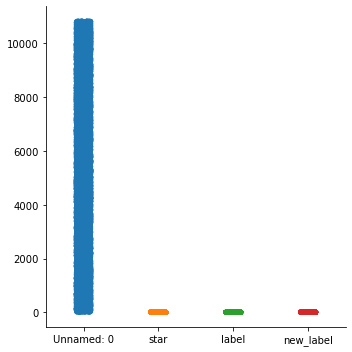

In [42]:
sns.catplot(data = data)

In [6]:
data = pd.read_csv('D:\polo_main.csv')

In [7]:
data['label'] = np.select([data.star > 3], [1], default=0)

In [8]:
data['new_label']=None

In [12]:
for i in range(len(data['comment'])):
    if sentiment_predict(data['comment'][i]) == 1:
        data['new_label'][i] = 1
    elif sentiment_predict(data['comment'][i]) == 0:
        data['new_label'][i] = 0
    else:
        data['new_label'][i] = -1

1/1 [==============================] - 0s 19ms/step
99.42% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
99.34% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
99.82% 확률로 부정 리뷰입니다.


C:\Users\jeonj\AppData\Local\Temp\ipykernel_9880\2238491664.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['new_label'][i] = 1


1/1 [==============================] - 0s 18ms/step
99.82% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
97.29% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
65.03% 확률로 긍정 리뷰입니다.


C:\Users\jeonj\AppData\Local\Temp\ipykernel_9880\2238491664.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['new_label'][i] = -1


1/1 [==============================] - 0s 17ms/step
92.15% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
99.02% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
97.99% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 16ms/step
95.81% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
78.84% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
99.20% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
99.30% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
86.45% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.05% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.36% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
99.22% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
99.22% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
99.30% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step

C:\Users\jeonj\AppData\Local\Temp\ipykernel_9880\2238491664.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['new_label'][i] = 0


1/1 [==============================] - 0s 19ms/step
96.85% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.85% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
96.11% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
98.10% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.38% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
97.50% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
87.42% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
87.42% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
97.53% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
98.19% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
93.96% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
95.20% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
95.20% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step

1/1 [==============================] - 0s 17ms/step
81.20% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
81.20% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.91% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 16ms/step
94.46% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
87.60% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 16ms/step
97.87% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
99.16% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.40% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
99.21% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
81.59% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.15% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.81% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
93.06% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step

1/1 [==============================] - 0s 18ms/step
95.98% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
93.14% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
97.21% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
57.75% 확률로 중립 리뷰입니다.
1/1 [==============================] - 0s 16ms/step
57.75% 확률로 중립 리뷰입니다.
1/1 [==============================] - 0s 16ms/step
96.69% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
96.44% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
97.11% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
90.03% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
90.03% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
95.73% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
96.97% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 25ms/step
99.89% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 16ms/step

1/1 [==============================] - 0s 24ms/step
96.86% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
94.32% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 16ms/step
99.06% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 16ms/step
93.06% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
99.03% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
96.65% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 16ms/step
81.71% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 36ms/step
81.71% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 32ms/step
97.32% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
45.45% 확률로 중립 리뷰입니다.
1/1 [==============================] - 0s 25ms/step
45.45% 확률로 중립 리뷰입니다.
1/1 [==============================] - 0s 16ms/step
96.18% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 16ms/step
91.59% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 32ms/step

1/1 [==============================] - 0s 18ms/step
92.96% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 16ms/step
92.96% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
92.85% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
92.85% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 24ms/step
96.86% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
96.86% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
99.44% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
96.43% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
92.97% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.61% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.61% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
97.69% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
97.97% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step

1/1 [==============================] - 0s 16ms/step
95.09% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
62.88% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
62.88% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
97.99% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
96.40% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.85% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.85% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
96.61% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.97% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.97% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.97% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.47% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.78% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step

1/1 [==============================] - 0s 16ms/step
91.39% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 16ms/step
91.39% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 24ms/step
99.06% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 24ms/step
96.76% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 25ms/step
95.11% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
94.14% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 28ms/step
97.46% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 16ms/step
99.32% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 26ms/step
97.62% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 6ms/step
40.48% 확률로 중립 리뷰입니다.
1/1 [==============================] - 0s 32ms/step
40.48% 확률로 중립 리뷰입니다.
1/1 [==============================] - 0s 32ms/step
79.35% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 22ms/step
79.35% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 31ms/step
78.65% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 32ms/step
78.65% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 31ms/step
73.92% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 31ms/step
91.32% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 16ms/step
97.59% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 32ms/step
95.58% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 25ms/step
98.15% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 16ms/step
97.76% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 16ms/step
95.59% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 32ms/step
95.85% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 32ms/step
95.85% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 13ms/step
95.85% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 14ms/step
59.75% 확률로 중립 리뷰입니다.
1/1 [==============================] - 0s 15ms/step

1/1 [==============================] - 0s 16ms/step
99.53% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 16ms/step
99.31% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 16ms/step
99.31% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 16ms/step
98.19% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 31ms/step
95.44% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 16ms/step
98.37% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.48% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
76.33% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
99.01% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
97.96% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
94.53% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
82.45% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
95.33% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step

1/1 [==============================] - 0s 19ms/step
47.90% 확률로 중립 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
94.81% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
99.13% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
95.48% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
95.72% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
96.43% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.81% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
88.48% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
69.29% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
93.79% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
82.45% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 23ms/step
98.27% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
98.04% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step

1/1 [==============================] - 0s 18ms/step
99.28% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.88% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
97.39% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 22ms/step
98.61% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
96.35% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
93.90% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
99.07% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
97.79% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
99.14% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
93.58% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
93.58% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
92.07% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
92.96% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step

1/1 [==============================] - 0s 20ms/step
96.74% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.82% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
96.73% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
99.27% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
99.27% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
91.05% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
99.75% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
99.75% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
97.27% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
97.27% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
96.69% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
96.69% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
93.83% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step

1/1 [==============================] - 0s 17ms/step
96.95% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
61.71% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
61.71% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
99.19% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
99.26% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
99.40% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 24ms/step
98.16% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 26ms/step
93.68% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.05% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 24ms/step
99.07% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
61.67% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
61.67% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
99.14% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 18ms/step
95.66% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 25ms/step
94.94% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 23ms/step
99.11% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 29ms/step
99.31% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
99.00% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.05% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
93.88% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.13% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.48% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.28% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
97.76% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 34ms/step
81.70% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
90.32% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step

1/1 [==============================] - 0s 19ms/step
94.34% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
92.77% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
97.18% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
99.13% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
87.22% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
99.25% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.67% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
91.96% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 22ms/step
87.25% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
99.10% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
95.67% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
95.67% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
98.96% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 18ms/step
68.89% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
68.89% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
94.43% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
87.12% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.60% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
90.44% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
97.90% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
97.25% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
97.25% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.33% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
96.29% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
92.60% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
95.14% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step

1/1 [==============================] - 0s 19ms/step
99.65% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
96.82% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
95.65% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
94.38% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.84% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
98.84% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.31% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
93.83% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
93.31% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
97.81% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
93.83% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.32% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.25% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 19ms/step
98.72% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.46% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
86.57% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
92.96% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
69.30% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
69.30% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.43% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
99.14% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.86% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
93.61% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
96.72% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
97.48% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
97.48% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step

1/1 [==============================] - 0s 17ms/step
93.79% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
94.68% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
95.56% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
97.18% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
97.16% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
87.87% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
60.92% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
60.92% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
97.75% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
91.28% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
96.97% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
93.37% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.57% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 16ms/step

1/1 [==============================] - 0s 17ms/step
98.86% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
98.86% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
60.79% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.92% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
56.98% 확률로 중립 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
56.98% 확률로 중립 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
62.84% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
62.84% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.83% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.83% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.83% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
97.71% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
73.63% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step

1/1 [==============================] - 0s 18ms/step
76.25% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
76.25% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
97.55% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.81% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
94.88% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
94.88% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
47.25% 확률로 중립 리뷰입니다.
1/1 [==============================] - 0s 26ms/step
47.25% 확률로 중립 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
78.11% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
78.11% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
97.63% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
97.51% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
90.76% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 17ms/step
99.04% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
99.04% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
97.28% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
96.26% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.19% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
96.83% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
84.34% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
84.34% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
84.34% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.39% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
97.08% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 16ms/step
62.44% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
62.44% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step

1/1 [==============================] - 0s 18ms/step
84.22% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
84.22% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
99.07% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
97.79% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
97.43% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 26ms/step
81.00% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
95.11% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
52.38% 확률로 중립 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
52.38% 확률로 중립 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.30% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
99.10% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
98.60% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.60% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step

1/1 [==============================] - 0s 16ms/step
98.47% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.47% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
93.84% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.92% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
96.42% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
96.09% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
96.09% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
73.45% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
73.45% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
94.29% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
65.68% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
65.68% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
97.96% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step

1/1 [==============================] - 0s 18ms/step
96.30% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
95.39% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.93% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
72.86% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
99.07% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.88% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
93.50% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
97.89% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
96.66% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
96.66% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
61.41% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 16ms/step
99.31% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
99.32% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step

1/1 [==============================] - 0s 17ms/step
92.79% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
81.17% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
81.17% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.12% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
97.12% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
99.57% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
99.57% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.77% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
88.07% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
88.07% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
95.61% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
95.80% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.77% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step

1/1 [==============================] - 0s 18ms/step
72.84% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
95.71% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
96.04% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.96% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
96.69% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
96.31% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
49.92% 확률로 중립 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
49.92% 확률로 중립 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
99.37% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
84.28% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 16ms/step
98.48% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
96.14% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
92.25% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step

1/1 [==============================] - 0s 17ms/step
94.37% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 16ms/step
94.37% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
94.84% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
96.71% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.08% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
60.23% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
92.43% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
92.43% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.67% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.42% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 16ms/step
98.61% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.61% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.61% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step

1/1 [==============================] - 0s 18ms/step
98.84% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
74.91% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
97.89% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
97.89% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
89.25% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.90% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
78.02% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
97.22% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
94.67% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
94.67% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.35% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
95.47% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
95.47% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step

1/1 [==============================] - 0s 17ms/step
76.63% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
62.80% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
96.66% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
95.32% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.32% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
97.59% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
92.56% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
89.80% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
60.69% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
60.69% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
76.74% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
76.74% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
94.40% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step

1/1 [==============================] - 0s 18ms/step
99.53% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
92.62% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
88.03% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
96.13% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
83.68% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
83.68% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 22ms/step
97.09% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
97.09% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.67% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
94.75% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
99.13% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
99.13% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
97.13% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step

1/1 [==============================] - 0s 17ms/step
95.59% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
99.38% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.85% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
97.59% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.64% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
97.12% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
97.12% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
74.70% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
74.70% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
74.70% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
74.70% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
74.70% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
74.70% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step

1/1 [==============================] - 0s 17ms/step
98.71% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
97.56% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
78.46% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 16ms/step
88.84% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
93.53% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
63.55% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
93.75% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
90.13% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
86.86% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
77.83% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
77.83% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
90.73% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
99.10% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step

1/1 [==============================] - 0s 17ms/step
88.59% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
88.59% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
99.15% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.83% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
93.84% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.81% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
81.86% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
81.86% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
81.86% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
81.86% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
60.87% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
88.18% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
88.18% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step

1/1 [==============================] - 0s 18ms/step
97.24% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
83.41% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.03% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.75% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
94.85% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
96.45% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
96.45% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
86.15% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
82.64% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
73.65% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
92.29% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
88.96% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
94.87% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step

1/1 [==============================] - 0s 17ms/step
54.94% 확률로 중립 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
54.94% 확률로 중립 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
54.94% 확률로 중립 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
54.94% 확률로 중립 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
54.94% 확률로 중립 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
93.92% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.89% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
97.54% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
93.19% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
83.82% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
74.76% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
74.76% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
93.91% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step

1/1 [==============================] - 0s 18ms/step
96.57% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.43% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.43% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
84.19% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
84.19% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
84.19% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
88.68% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
88.68% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
88.68% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
96.36% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
96.94% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
99.65% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.92% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step

1/1 [==============================] - 0s 19ms/step
93.68% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
94.55% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.74% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
86.62% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
99.14% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
72.27% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
72.44% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
99.14% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
47.24% 확률로 중립 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
47.24% 확률로 중립 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
91.84% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
82.45% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
99.33% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step

1/1 [==============================] - 0s 17ms/step
95.54% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
92.59% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.15% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
89.89% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
89.89% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
86.38% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
86.38% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
86.38% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.83% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
80.18% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
80.18% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
95.86% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
95.86% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step

1/1 [==============================] - 0s 18ms/step
98.92% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
99.08% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
96.44% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
97.12% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
94.13% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.47% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.47% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.47% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
87.76% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
90.16% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
96.14% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
90.58% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.43% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step

1/1 [==============================] - 0s 18ms/step
93.84% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
92.79% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
94.00% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.55% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
99.30% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
78.95% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
93.07% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
97.63% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
95.04% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
97.77% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
96.83% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
72.99% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
95.41% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step

1/1 [==============================] - 0s 17ms/step
97.42% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.84% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.84% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
96.78% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
96.78% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
91.70% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
90.50% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
97.96% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
96.78% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
96.78% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
97.32% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
97.32% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
96.57% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step

1/1 [==============================] - 0s 17ms/step
98.09% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
96.81% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
94.57% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
83.05% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.85% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.41% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.51% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
97.58% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
41.87% 확률로 중립 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
41.87% 확률로 중립 리뷰입니다.
1/1 [==============================] - 0s 16ms/step
93.73% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
97.72% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
96.53% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step

1/1 [==============================] - 0s 17ms/step
92.67% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
97.65% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
96.00% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.67% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
89.61% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
99.76% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
99.76% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.57% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
99.10% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
99.10% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.88% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
94.06% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
97.85% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step

1/1 [==============================] - 0s 39ms/step
96.27% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
97.55% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
97.13% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
93.74% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
97.98% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
90.01% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
99.11% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
99.01% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 22ms/step
99.01% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
94.81% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
94.81% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
93.16% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
95.32% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 17ms/step
98.76% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
45.99% 확률로 중립 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
45.99% 확률로 중립 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
92.83% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.91% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.91% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
99.16% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
95.54% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
95.54% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
89.13% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
89.13% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
97.86% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.53% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step

1/1 [==============================] - 0s 17ms/step
98.58% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
97.62% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
97.62% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
82.75% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
93.21% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
96.72% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
97.50% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
97.50% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
99.05% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
91.37% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
99.16% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
97.54% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.90% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step

1/1 [==============================] - 0s 22ms/step
99.10% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
97.97% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
97.04% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
97.91% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
97.97% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
68.58% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.97% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
94.85% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
94.85% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.74% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.74% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
90.88% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
96.72% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step

1/1 [==============================] - 0s 18ms/step
97.61% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
95.52% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
93.21% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
99.14% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
95.59% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
95.59% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.35% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
95.42% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
94.58% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
99.48% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
97.16% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.75% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
84.38% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step

1/1 [==============================] - 0s 18ms/step
98.99% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.99% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.31% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.31% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.31% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.71% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
99.35% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
93.89% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
82.75% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
99.17% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
87.88% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.41% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.78% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step

1/1 [==============================] - 0s 17ms/step
99.68% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
94.93% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
94.19% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
90.19% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
97.73% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
94.99% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
91.38% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
97.12% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
93.75% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
88.79% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
88.87% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
88.87% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
88.88% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step

1/1 [==============================] - 0s 17ms/step
87.73% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
82.45% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
80.33% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 16ms/step
80.33% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
79.99% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
90.55% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
96.48% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
96.05% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
82.10% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
82.10% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
87.71% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
97.44% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
90.27% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step

1/1 [==============================] - 0s 17ms/step
97.75% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
99.30% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.31% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
91.16% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
96.77% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
93.99% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
93.99% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.59% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
95.78% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
91.28% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
91.28% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
80.95% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
80.95% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step

1/1 [==============================] - 0s 17ms/step
64.00% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
96.12% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
96.12% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.32% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
42.53% 확률로 중립 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
42.53% 확률로 중립 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
99.13% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.85% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.76% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
78.67% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
78.67% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
99.91% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 16ms/step
99.91% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 16ms/step

1/1 [==============================] - 0s 18ms/step
95.06% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
97.24% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
77.04% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
77.04% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
97.14% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.54% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
99.03% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.07% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.07% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.07% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.55% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
90.54% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
90.54% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step

1/1 [==============================] - 0s 17ms/step
99.15% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
91.98% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
97.10% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.49% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.80% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
86.66% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
86.66% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.21% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
99.25% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
95.11% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
93.84% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
97.93% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
75.33% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step

1/1 [==============================] - 0s 17ms/step
96.78% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
83.96% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.73% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.56% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
78.56% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.21% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.20% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.20% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.20% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
87.94% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
87.94% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
99.09% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
85.87% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step

1/1 [==============================] - 0s 17ms/step
85.06% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
85.06% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
97.95% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
99.43% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
97.65% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
61.92% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.45% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.45% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.96% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
92.74% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
87.04% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
92.88% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
90.27% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 16ms/step

1/1 [==============================] - 0s 20ms/step
86.59% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 25ms/step
86.59% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 22ms/step
89.81% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 42ms/step
99.40% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.51% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
96.99% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
98.37% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 23ms/step
98.23% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
97.56% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
97.47% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
99.03% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
96.38% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.19% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step

1/1 [==============================] - 0s 18ms/step
98.33% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
94.85% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
79.12% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
95.33% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
96.89% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
93.80% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
44.01% 확률로 중립 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
44.01% 확률로 중립 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
98.42% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
69.91% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 25ms/step
69.91% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
98.94% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 23ms/step
85.01% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 18ms/step
99.13% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 16ms/step
84.51% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
84.51% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
97.93% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
91.85% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
91.85% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
96.42% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
97.85% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
91.74% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
64.56% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
99.03% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
97.77% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.48% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 16ms/step

1/1 [==============================] - 0s 19ms/step
72.32% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
51.42% 확률로 중립 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
51.42% 확률로 중립 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
96.60% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
57.25% 확률로 중립 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
57.25% 확률로 중립 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
97.22% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
95.25% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.96% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.96% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
65.72% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
65.72% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
97.98% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step

1/1 [==============================] - 0s 17ms/step
99.17% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
99.17% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
99.27% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
97.05% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.82% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
99.26% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
99.26% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
96.92% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
96.92% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
96.92% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
96.92% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
96.92% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
96.92% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step

1/1 [==============================] - 0s 18ms/step
98.67% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
96.74% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.60% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
84.96% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.97% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
96.65% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
97.18% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
96.88% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
96.88% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
87.10% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
95.81% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
70.80% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
94.05% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step

1/1 [==============================] - 0s 18ms/step
76.97% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
76.97% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
86.96% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
90.51% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
90.93% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
91.03% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
79.81% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
96.75% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
96.75% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
96.75% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
86.84% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
99.08% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
99.08% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step

1/1 [==============================] - 0s 18ms/step
96.81% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.52% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.51% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.20% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
90.30% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
69.20% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
72.70% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
72.70% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.44% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.44% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
96.17% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
75.15% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.78% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step

1/1 [==============================] - 0s 17ms/step
97.32% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
96.94% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.63% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
95.07% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
96.83% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
93.78% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
93.78% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.61% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
76.10% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.94% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.94% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
95.76% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.41% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step

1/1 [==============================] - 0s 17ms/step
95.08% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
93.76% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 16ms/step
96.51% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
96.51% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
97.40% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
97.40% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
99.07% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
93.13% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
97.61% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
57.59% 확률로 중립 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
57.59% 확률로 중립 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
93.26% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
45.30% 확률로 중립 리뷰입니다.
1/1 [==============================] - 0s 17ms/step

1/1 [==============================] - 0s 17ms/step
77.25% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
93.81% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
92.89% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.80% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
79.05% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.63% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.88% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
92.03% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
92.03% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
92.03% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
92.03% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
92.03% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
92.03% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step

1/1 [==============================] - 0s 17ms/step
93.31% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
92.81% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
93.67% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
94.05% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
99.03% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
65.00% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
65.00% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
65.00% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
65.00% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
97.52% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
94.35% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.74% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
88.12% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step

1/1 [==============================] - 0s 18ms/step
98.70% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
93.61% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
97.06% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
96.34% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
93.75% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
92.83% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.08% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.08% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.11% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
96.81% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
96.32% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
91.16% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
88.75% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step

1/1 [==============================] - 0s 17ms/step
96.27% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
90.16% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
90.16% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
92.60% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
80.32% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
94.73% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.76% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
96.34% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
99.01% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
97.69% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
89.69% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
79.39% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
79.39% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step

1/1 [==============================] - 0s 18ms/step
95.91% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
81.21% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
81.21% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
81.21% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
81.21% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
85.70% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
89.75% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
85.70% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.10% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
87.21% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
87.21% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
91.05% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
78.54% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step

1/1 [==============================] - 0s 18ms/step
47.56% 확률로 중립 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
79.66% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 16ms/step
99.31% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.66% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.52% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
94.40% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
91.00% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
95.56% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
40.16% 확률로 중립 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
40.16% 확률로 중립 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
99.29% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
93.25% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
66.77% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step

1/1 [==============================] - 0s 17ms/step
98.68% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
88.01% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
97.49% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.14% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
95.73% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
95.73% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
95.73% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
99.22% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.47% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.47% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
88.58% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
68.64% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
94.95% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step

1/1 [==============================] - 0s 18ms/step
97.67% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
94.63% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.48% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.96% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
97.18% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
93.42% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
91.81% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
97.08% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
99.33% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.70% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
78.49% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
90.35% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.87% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step

1/1 [==============================] - 0s 18ms/step
95.87% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
95.87% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
95.87% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
95.87% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 27ms/step
60.16% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
60.16% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
93.12% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
93.12% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
93.12% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
88.26% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
96.81% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
99.01% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
84.65% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step

1/1 [==============================] - 0s 18ms/step
71.74% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
89.86% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
72.26% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.44% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.96% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
96.59% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
99.32% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
65.72% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
65.72% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
82.45% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
97.63% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 16ms/step
94.88% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
99.13% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step

1/1 [==============================] - 0s 17ms/step
96.02% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
74.81% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
97.79% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
96.52% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
96.52% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
94.88% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
96.01% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
95.83% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
93.25% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.60% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.33% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
99.29% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
97.89% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step

1/1 [==============================] - 0s 17ms/step
95.13% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.94% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.57% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
99.09% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
85.91% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
99.16% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
96.54% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
99.11% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
93.67% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
93.67% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
76.78% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
76.78% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
76.78% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step

1/1 [==============================] - 0s 18ms/step
98.46% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.46% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
44.30% 확률로 중립 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
44.30% 확률로 중립 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
97.86% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 16ms/step
97.78% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
93.68% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
93.14% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.23% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
95.75% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
69.61% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
99.31% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
99.00% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step

1/1 [==============================] - 0s 18ms/step
98.08% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
76.78% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
76.78% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 16ms/step
91.06% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
96.21% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
99.16% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
59.58% 확률로 중립 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
59.58% 확률로 중립 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
94.81% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.81% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
93.84% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
99.43% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.95% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step

1/1 [==============================] - 0s 17ms/step
91.94% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
91.94% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.51% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
91.32% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
96.25% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
41.57% 확률로 중립 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
41.57% 확률로 중립 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
84.90% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
84.90% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
96.09% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
99.46% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
99.00% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
96.99% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step

1/1 [==============================] - 0s 17ms/step
98.53% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.53% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.53% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.53% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.53% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.75% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
91.69% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
91.69% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.52% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
96.68% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
96.68% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
96.68% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
96.68% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step

1/1 [==============================] - 0s 17ms/step
92.50% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
87.51% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
94.44% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
96.71% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
96.71% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.50% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
97.93% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.51% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.87% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.62% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
93.31% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
99.19% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
53.74% 확률로 중립 리뷰입니다.
1/1 [==============================] - 0s 17ms/step

1/1 [==============================] - 0s 19ms/step
99.69% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 16ms/step
99.15% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
82.45% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
92.29% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
97.72% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
72.79% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
72.79% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
99.36% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
94.16% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
94.16% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
96.17% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.07% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
67.24% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step

1/1 [==============================] - 0s 17ms/step
94.79% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
94.79% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.66% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
99.11% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
99.11% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
96.06% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
96.06% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
93.89% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
95.83% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
94.55% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 25ms/step
93.95% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
93.95% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.70% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step

1/1 [==============================] - 0s 17ms/step
69.88% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
86.23% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
99.42% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.64% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
80.80% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
99.20% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
78.77% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
96.33% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.91% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
99.00% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
89.68% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
83.21% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.25% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step

1/1 [==============================] - 0s 18ms/step
86.07% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
95.13% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
99.39% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.65% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
93.22% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.60% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
92.54% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
92.54% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
83.71% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
83.71% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
62.30% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
62.30% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
99.20% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step

1/1 [==============================] - 0s 18ms/step
96.65% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
96.65% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
96.65% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
95.75% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
97.18% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
96.99% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
97.77% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
96.76% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
54.45% 확률로 중립 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
54.45% 확률로 중립 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
91.59% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.18% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
93.00% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 18ms/step
90.86% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
90.86% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
84.78% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
96.75% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
99.10% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.31% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
92.52% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.81% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
97.77% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
97.72% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
97.01% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.94% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
88.49% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step

1/1 [==============================] - 0s 17ms/step
98.11% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.52% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.52% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
86.16% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
97.55% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
96.37% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
96.37% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
90.82% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
93.71% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
97.90% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
96.99% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
92.48% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
96.19% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step

1/1 [==============================] - 0s 17ms/step
97.13% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
95.36% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
96.90% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
74.53% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
97.73% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
97.73% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
85.41% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
99.00% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
99.00% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
96.80% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
63.98% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
91.50% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.91% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step

1/1 [==============================] - 0s 18ms/step
97.24% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
99.34% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
99.04% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
96.59% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
96.29% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
84.19% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
93.50% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
93.50% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
95.61% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
77.75% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
77.75% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
77.75% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
92.92% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step

1/1 [==============================] - 0s 17ms/step
99.05% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.17% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
96.30% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
96.30% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
94.33% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
95.50% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
90.19% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
90.19% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
96.93% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
97.99% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
79.96% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
79.96% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
95.42% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step

1/1 [==============================] - 0s 17ms/step
98.13% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
97.92% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
85.64% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
85.64% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
91.19% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
80.25% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
80.25% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
80.25% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
80.25% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
80.25% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
80.25% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
86.60% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
86.60% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step

1/1 [==============================] - 0s 17ms/step
96.77% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
94.04% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
99.58% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
99.08% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
96.98% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
95.78% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
89.33% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
89.33% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
82.45% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
99.15% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
99.10% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
51.01% 확률로 중립 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
51.01% 확률로 중립 리뷰입니다.
1/1 [==============================] - 0s 18ms/step

1/1 [==============================] - 0s 17ms/step
88.99% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
77.98% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
95.76% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
95.76% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
93.00% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
93.00% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.22% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.13% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
99.30% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
99.30% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.99% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
96.65% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
84.48% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step

1/1 [==============================] - 0s 18ms/step
96.33% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
82.44% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
82.44% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
96.84% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
95.94% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
95.49% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
90.81% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
94.48% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
97.73% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.28% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
97.40% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
67.18% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
67.18% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step

1/1 [==============================] - 0s 19ms/step
98.06% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
76.58% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
76.58% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
99.67% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
99.67% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
94.79% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.05% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
97.38% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
86.30% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
86.30% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
99.13% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
99.38% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
99.38% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step

1/1 [==============================] - 0s 18ms/step
97.14% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.66% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
94.25% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
97.88% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.47% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
77.32% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.01% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
99.03% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
74.92% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
93.00% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
97.95% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.33% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.94% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step

1/1 [==============================] - 0s 20ms/step
98.76% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.04% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
90.79% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
90.24% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
99.40% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
99.47% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
96.06% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
84.29% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
94.50% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
94.50% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.87% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.87% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
75.33% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step

1/1 [==============================] - 0s 17ms/step
89.03% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
96.68% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
93.88% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
89.57% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
96.80% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
94.91% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
99.19% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
99.19% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
90.55% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
90.55% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
91.79% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
95.26% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
95.77% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step

1/1 [==============================] - 0s 17ms/step
87.08% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
87.08% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
76.33% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
97.59% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
96.97% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
96.93% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
60.13% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
87.44% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.40% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
90.66% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
90.66% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.92% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.68% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step

1/1 [==============================] - 0s 19ms/step
97.70% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.92% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.92% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
73.19% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
93.75% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
76.01% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
76.01% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
86.59% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
45.73% 확률로 중립 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
45.73% 확률로 중립 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
97.04% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
51.02% 확률로 중립 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
51.02% 확률로 중립 리뷰입니다.
1/1 [==============================] - 0s 17ms/step

1/1 [==============================] - 0s 18ms/step
98.36% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
47.38% 확률로 중립 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
47.38% 확률로 중립 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
99.53% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
99.53% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.32% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
95.19% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
95.19% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.22% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
94.50% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
90.84% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.08% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.74% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step

1/1 [==============================] - 0s 17ms/step
99.20% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
88.77% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
97.31% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.44% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
92.44% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
80.73% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.61% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
75.92% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
89.09% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.83% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
99.46% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
49.02% 확률로 중립 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
49.02% 확률로 중립 리뷰입니다.
1/1 [==============================] - 0s 17ms/step

1/1 [==============================] - 0s 17ms/step
76.78% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
76.78% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
76.78% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
76.78% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
76.78% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
76.78% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
76.78% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
76.78% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
76.78% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
76.78% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
76.78% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
76.78% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
76.78% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step

In [15]:
data['label']

0        1
1        1
2       -1
3        1
4        1
        ..
10833    1
10834    1
10835    1
10836    1
10837    1
Name: label, Length: 10838, dtype: int32

In [20]:
import collections
collections.Counter(data['label'])

Counter({1: 10150, -1: 17, 0: 671})

In [21]:
collections.Counter(data['new_label'])

Counter({1: 9605, -1: 948, 0: 285})

In [38]:
print('기존의 긍/부정 비율: '+str(round(collections.Counter(data['label'])[1]/(collections.Counter(data['label'])[1]+collections.Counter(data['label'])[-1]+collections.Counter(data['label'])[0])*100, 2))+'%')

기존의 긍/부정 비율: 93.65%


In [39]:
print('조정된 긍/부정 비율: '+str(round(collections.Counter(data['new_label'])[1]/(collections.Counter(data['new_label'])[1]+collections.Counter(data['new_label'])[-1]+collections.Counter(data['new_label'])[0])*100, 2))+'%')

조정된 긍/부정 비율: 88.62%


In [48]:
data.to_csv('D:\sample.csv',encoding='utf-8-sig')